In [2]:
#Installs Fastbook and necessary components
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *


     |████████████████████████████████| 727kB 30.2MB/s 
     |████████████████████████████████| 1.2MB 44.1MB/s 
     |████████████████████████████████| 194kB 34.5MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
Mounted at /content/gdrive


In [7]:
#Initializes bing search and test downloading 150 grizzly bear pictures.
azureKey = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx'
key = os.environ.get('AZURE_SEARCH_KEY', azureKey)
search_images_bing
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [8]:
#Initalizes bear_types to include 7 of the 8 bears, and path to now have the bear directory.
bear_types = 'grizzly','black','polar', 'panda', 'andean', 'sloth', 'sun'
path = Path('bears')

In [10]:
#Check to see if the bear path exist. If not, creates it, and begins downloading pictures of each bear type. 
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
#Stores the bear image path in fns. Check eath file to see if they are an image. Deletes the ones that are not.
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);

In [12]:
#Prints fns and failed variables
fns
failed

(#4) [Path('bears/andean/00000049.jpg'),Path('bears/sun/00000148.jpg'),Path('bears/black/00000030.jpg'),Path('bears/black/00000004.png')]

In [13]:
#Creates a data block called bears with Random Resized Crop.
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128, min_scale=0.3))

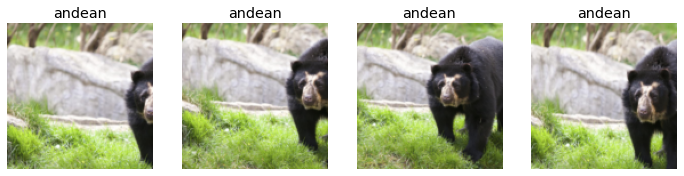

In [14]:
#Tells the learner where the images can be found.
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [15]:
#Intializes the model to a Resnet 152,and begins to learn with 6 epochs
learn = cnn_learner(dls, resnet152, metrics=error_rate)
learn.fine_tune(6)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.510427,0.739626,0.139037,00:42


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.443233,0.490210,0.149733,00:42
1,0.366116,0.393820,0.101604,00:43
2,0.310264,0.362180,0.069519,00:42
3,0.272781,0.311576,0.074866,00:42
4,0.220685,0.277742,0.064171,00:42
5,0.190834,0.278749,0.064171,00:43


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


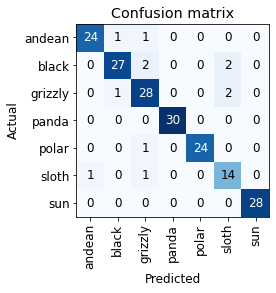

In [16]:
#Prints out the Confusion Matrix: Helps to identify where mistakes were made.
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

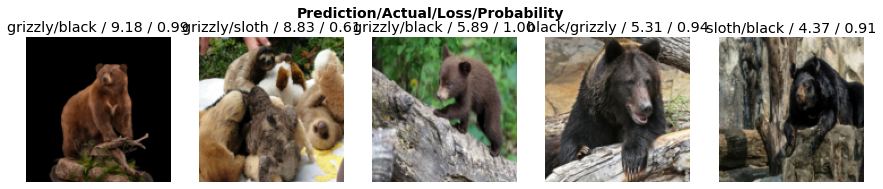

In [17]:
#Prints out the the images with the highest loss.
interp.plot_top_losses(5, nrows=1)

In [18]:
#Allows to delete, and change unwanted photos that could be negatively affecting the model.
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#Cleans out the unwanted photos selected above.
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [19]:
#Exports the model as "export.pkl"
learn.export()

In [20]:
#Resets the path to home directory. Checks to see if a pkl file exists. Loads the "export.pkl" model.
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')

In [24]:
#Creates a GUI interface to allow a user to classify bears.
btn_run = widgets.Button(description='Classify') #Creates a run button called classify
btn_upload = widgets.FileUpload() #Creates an upload button for pictures of bears
out_pl = widgets.Output()
lbl_pred = widgets.Label()
out_pl.clear_output()

#Take the picture in btn_upload, run it through the model, and return to the user the bear type with the highest preduction
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

#Diplays all the widgets below.
btn_run.on_click(on_click_classify)
with out_pl: display(img.to_thumb(128,128))
VBox([widgets.Label('Select your bear!'), btn_upload, btn_run, out_pl, lbl_pred])